In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [59]:
df = pd.read_csv('/content/drive/MyDrive/MTech/Project/new_cleaned.csv')

In [60]:
df.head()

,property_type,society,sector,price,price_per_sqft,bedRoom,bathroom,balcony,floorNum,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type
0,flat,maa bhagwati residency,krishna colony,0.45,5000.0,2,2,1,4,relativelt new,1895.94987,1600.0,900.0,0,0,0,0,0,2
1,flat,apna enclave,ashok vihar,0.50,7692.0,2,2,1,1,old property,1895.94987,1600.0,650.0,0,0,0,0,0,0
2,flat,tulsiani easy in homes,sohna,0.40,6722.0,2,2,3,12,new Property,1895.94987,1600.0,595.0,0,0,0,0,0,2
3,flat,smart world orchard,sector 61,1.47,12250.0,2,2,2,2,under construction,1895.94987,1600.0,1200.0,1,0,0,0,0,2
4,flat,parkwood westend,sector 92,0.70,5204.0,2,2,3,5,under construction,1345.00000,1600.0,1254.0,1,0,0,0,0,2


In [61]:
df.shape

(3767, 19)

In [62]:
df = df.drop(columns=['society','sector'])

## **FloorNum**

In [8]:
df['floorNum'] = df['floorNum'].astype(float)
def categorize_floor(floor):
    if 0 <= floor <= 2:
        return "Low Floor"
    elif 3 <= floor <= 10:
        return "Mid Floor"
    elif 11 <= floor <= 51:
        return "High Floor"
    else:
        return None

In [9]:
df['floor_category'] = df['floorNum'].apply(categorize_floor)


In [10]:
df = df.drop(columns=['floorNum'])

In [11]:
df.head()

,property_type,price,price_per_sqft,bedRoom,bathroom,balcony,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,floor_category
0,flat,0.45,5000.0,2,2,1,relativelt new,1895.94987,1600.0,900.0,0,0,0,0,0,2,Mid Floor
1,flat,0.50,7692.0,2,2,1,old property,1895.94987,1600.0,650.0,0,0,0,0,0,0,Low Floor
2,flat,0.40,6722.0,2,2,3,new Property,1895.94987,1600.0,595.0,0,0,0,0,0,2,High Floor
3,flat,1.47,12250.0,2,2,2,under construction,1895.94987,1600.0,1200.0,1,0,0,0,0,2,Low Floor
4,flat,0.70,5204.0,2,2,3,under construction,1345.00000,1600.0,1254.0,1,0,0,0,0,2,Mid Floor


In [12]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3767 entries, 0 to 3766
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_type        3767 non-null   object 
 1   price                3767 non-null   float64
 2   price_per_sqft       3767 non-null   float64
 3   bedRoom              3767 non-null   int64  
 4   bathroom             3767 non-null   int64  
 5   balcony              3767 non-null   object 
 6   agePossession        3767 non-null   object 
 7   super_built_up_area  3767 non-null   float64
 8   built_up_area        3767 non-null   float64
 9   carpet_area          3767 non-null   float64
 10  study room           3767 non-null   int64  
 11  servant room         3767 non-null   int64  
 12  store room           3767 non-null   int64  
 13  pooja room           3767 non-null   int64  
 14  others               3767 non-null   int64  
 15  furnishing_type      3767 non-null   i

In [13]:
data_label_encoded = df.copy()

categorical_cols = df.select_dtypes(include=['object']).columns

# Apply label encoding to categorical columns
for col in categorical_cols:
    oe = OrdinalEncoder()
    data_label_encoded[col] = oe.fit_transform(data_label_encoded[[col]])
    print(oe.categories_)

[array(['flat', 'house'], dtype=object)]
[array(['1', '2', '3', 'No'], dtype=object)]
[array(['moderately old', 'new Property', 'old property', 'relativelt new',
       'undefined', 'under construction'], dtype=object)]
[array(['High Floor', 'Low Floor', 'Mid Floor', None], dtype=object)]


In [14]:
X = data_label_encoded.drop('price', axis=1)
y = data_label_encoded['price']

# **Correlation Analysis**

<Axes: >

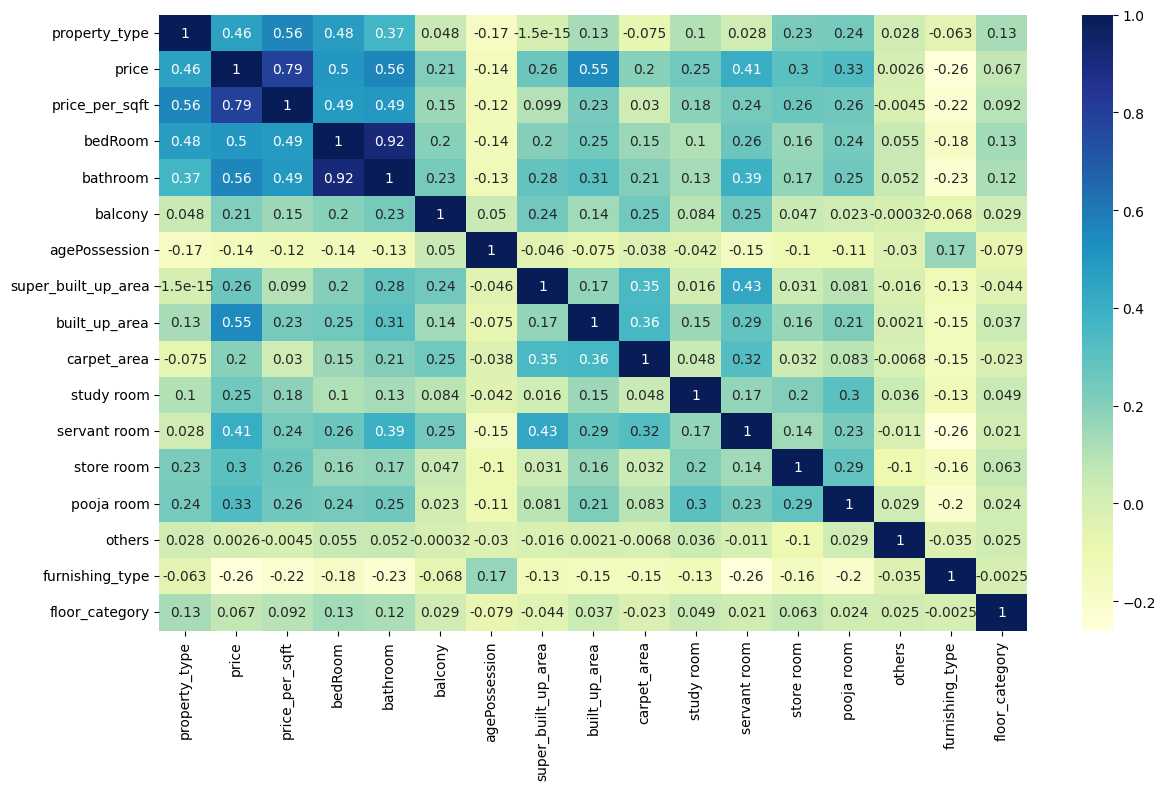

In [15]:
plt.figure(figsize=(14,8))
sns.heatmap(data_label_encoded.corr(), cmap="YlGnBu", annot=True)

# **Feature Importance**

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [47]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train a LASSO regression model
# We'll use a relatively small value for alpha (the regularization strength) for demonstration purposes
lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X_scaled, y)

# Extract coefficients
fi_df5 = pd.DataFrame({
    'feature': X.columns,
    'lasso_coeff': lasso.coef_
}).sort_values(by='lasso_coeff', ascending=False)

fi_df5

,feature,lasso_coeff
1,price_per_sqft,1.511586
7,built_up_area,0.818490
3,bathroom,0.297479
10,servant room,0.207988
6,super_built_up_area,0.198996
0,property_type,0.096916
11,store room,0.093569
9,study room,0.090636
12,pooja room,0.082256
4,balcony,0.014575


In [42]:
alphas = np.random.uniform(0, 20, 50)
lasso_cv = LassoCV(alphas = alphas)

lasso_cv

LassoCV(alphas=array([18.56321701, 13.03487541, 11.3724155 ,  1.58013338, 17.7275337 ,
       11.59468567, 17.72888481, 12.4176523 ,  0.08728224, 17.87368194,
       18.97286614,  3.37354467,  1.90850143, 16.46807169, 18.23931852,
        5.03344189, 11.74388646,  2.70722667,  2.27775696, 11.83279934,
       16.97061437,  9.89487873, 13.05337319, 12.62207355,  6.19104539,
       15.65328193, 10.30557932,  8.91025157,  6.29123641,  0.52439961,
        6.05231059,  8.68976718, 13.64225579,  3.93552846, 10.59856082,
       14.05317646, 13.89378827,  6.93906677,  8.22877779,  6.93320461,
        6.20289982,  7.00719717,  4.45079523, 10.17676354,  4.05021589,
       11.65489896, 15.18618983, 16.36627821, 10.60348794, 18.1003828 ]))

In [44]:
lasso_cv.fit(X_train, y_train)
best_alpha = lasso_cv.alpha_
best_alpha

0.08728223647100464

In [52]:
lasso = Lasso(alpha=0.087, random_state=42)
lasso.fit(X_train,y_train)
y_p_train_lasso = lasso.predict(X_train)
y_pred1 = lasso.predict(X_test)
print(f"R2 train: {r2_score(y_train,y_p_train_lasso)}")
print(f"R2 Lasso: {r2_score(y_test,y_pred1)}")
print(f"MSE Lasso: {mean_squared_error(y_test,y_pred1)}")
# 0.6700140618416541
# 0.7837176559201209


R2 train: 0.8022996181199282
R2 Lasso: 0.7826876069109578
MSE Lasso: 1.4032866185971689


In [53]:
linearReg = LinearRegression()
linearReg.fit(X_train,y_train)
y_p_train = linearReg.predict(X_train)
y_pred2 = linearReg.predict(X_test)
print(f"R2 train: {r2_score(y_train,y_p_train)}")
print(f"R2 Linear: {r2_score(y_test,y_pred2)}")
print(f"MSE Linear: {mean_squared_error(y_test,y_pred2)}")
# 0.6639170369902307
# 0.785277119164927

R2 train: 0.8102400945056702
R2 Linear: 0.7852771191649229
MSE Linear: 1.38656494044974


In [54]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
y_pred3 = rf.predict(X_test)
print(f"R2 RandomForest: {r2_score(y_test,y_pred3)}")
print(f"MSE RandomForest: {mean_squared_error(y_test,y_pred3)}")
# 0.7276769808245319
# 0.9090659582849572

R2 RandomForest: 0.9119562498325751
MSE RandomForest: 0.5685392107869144


In [55]:
data_label_encoded.head(1)
data_label_encoded.shape

(3767, 17)

In [57]:
df.describe()

,price,price_per_sqft,bedRoom,bathroom,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type
count,3767.000000,3767.000000,3767.000000,3767.000000,3767.000000,3767.000000,3767.00000,3767.000000,3767.000000,3767.000000,3767.000000,3767.00000,3767.000000
mean,2.272981,11706.786302,3.273427,3.317229,1895.949870,1675.512466,1306.26249,0.179719,0.339262,0.085745,0.164587,0.10884,1.388107
std,2.513688,8179.856810,1.916081,1.961655,500.837967,733.103363,559.57427,0.384004,0.473522,0.280024,0.370857,0.31148,0.892017
min,0.070000,544.000000,1.000000,1.000000,89.000000,14.000000,33.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.900000,6771.000000,2.000000,2.000000,1811.000000,1600.000000,1240.04000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,1.480000,8889.000000,3.000000,3.000000,1895.949870,1600.000000,1254.00000,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000
75%,2.500000,13392.000000,4.000000,4.000000,1895.949870,1600.000000,1300.00000,0.000000,1.000000,0.000000,0.000000,0.00000,2.000000
max,26.000000,60000.000000,36.000000,36.000000,4890.000000,9500.000000,9000.00000,1.000000,1.000000,1.000000,1.000000,1.00000,2.000000


In [65]:
df.columns

Index(['property_type', 'price', 'price_per_sqft', 'bedRoom', 'bathroom',
       'balcony', 'floorNum', 'agePossession', 'super_built_up_area',
       'built_up_area', 'carpet_area', 'study room', 'servant room',
       'store room', 'pooja room', 'others', 'furnishing_type'],
      dtype='object')

In [66]:
df.head()

,property_type,price,price_per_sqft,bedRoom,bathroom,balcony,floorNum,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type
0,flat,0.45,5000.0,2,2,1,4,relativelt new,1895.94987,1600.0,900.0,0,0,0,0,0,2
1,flat,0.50,7692.0,2,2,1,1,old property,1895.94987,1600.0,650.0,0,0,0,0,0,0
2,flat,0.40,6722.0,2,2,3,12,new Property,1895.94987,1600.0,595.0,0,0,0,0,0,2
3,flat,1.47,12250.0,2,2,2,2,under construction,1895.94987,1600.0,1200.0,1,0,0,0,0,2
4,flat,0.70,5204.0,2,2,3,5,under construction,1345.00000,1600.0,1254.0,1,0,0,0,0,2


In [67]:
data_label_encoded.head()

,property_type,price,price_per_sqft,bedRoom,bathroom,balcony,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,floor_category
0,0.0,0.45,5000.0,2,2,0.0,3.0,1895.94987,1600.0,900.0,0,0,0,0,0,2,2.0
1,0.0,0.50,7692.0,2,2,0.0,2.0,1895.94987,1600.0,650.0,0,0,0,0,0,0,1.0
2,0.0,0.40,6722.0,2,2,2.0,1.0,1895.94987,1600.0,595.0,0,0,0,0,0,2,0.0
3,0.0,1.47,12250.0,2,2,1.0,5.0,1895.94987,1600.0,1200.0,1,0,0,0,0,2,1.0
4,0.0,0.70,5204.0,2,2,2.0,5.0,1345.00000,1600.0,1254.0,1,0,0,0,0,2,2.0


In [70]:
data_label_encoded['agePossession'].value_counts() [array(['moderately old', 'new Property', 'old property', 'relativelt new',
       'undefined', 'under construction'], dtype=object)]

3.0    1632
1.0     622
0.0     567
4.0     337
2.0     326
5.0     283
Name: agePossession, dtype: int64

In [72]:
def format_price(price):
    if price < 1:
        return f"{price * 100:.0f} lakhs"
    else:
        return f"{price:.2f} crores"
# 1.25     82
# 1.50     70
# 1.10     69
# 0.90     69
# 1.20     66
# 1.40     64
# 1.30     64

In [74]:
format_price(0.90)

'90 lakhs'